# Stage 2

<br>

<font color=red>**최종 학습 목표**</font>

* 신용카드 사기거래 탐지 프로젝트를 통해 여러분은 이상치 감지를 훌륭히 수행할 수 있는 데이커가 되는 것에 한 발짝 더 다가가게 될 것입니다.

* 이 뿐만 아니라 이번 교육을 통해 키운 역량은 다른 곳에서도 큰 도움이 될 것이라 기대합니다.<br>

<br><font color=red>**Stage 6 학습 목표**</font>

* 학습한 내용을 바탕으로 사기거래 식별 모델링 성능을 올려본다.

* 상위권 코드를 이해하고 활용할 수 있다.

* 다양한 고급 데이터 사이언스 기법을 배운다.

<br>

# 1. Intro

<br>

**데이커 여러분 환영합니다.** 🤗 

지난 Stage 5에서는 데이터 시각화를 통해 Insight를 도출해보았습니다.
<br><br>
이번 Stage 6에서는 Insight를 토대로 공유된 Base Line 코드를 수정하여 성능을 올려보며 다양한 모델링을 수행해 볼 것입니다.
<br><br>

오늘 우리는 다양한 모델링 기법 중 <font color=darkblue>**Isolate Forest**</font>, <font color=red>**Elliptic Envelope**</font>, <font color=green>**지도 학습**</font>,  <font color=#FFA500>**Auto Encoder**</font>에 관하여 실습과 퀴즈를 통해 공부하게 될 것입니다.

퀴즈가 있다고 당황하지 마세요. <font color=red>**Hint**</font>가 여러분을 언제나 곁에서 도와줄 것입니다. 
<br><br>
그럼 이제 고고씽 ~ ! 🚅<br><br>

# 2. Stage 6에 앞서 대회 규칙 설명

<br>

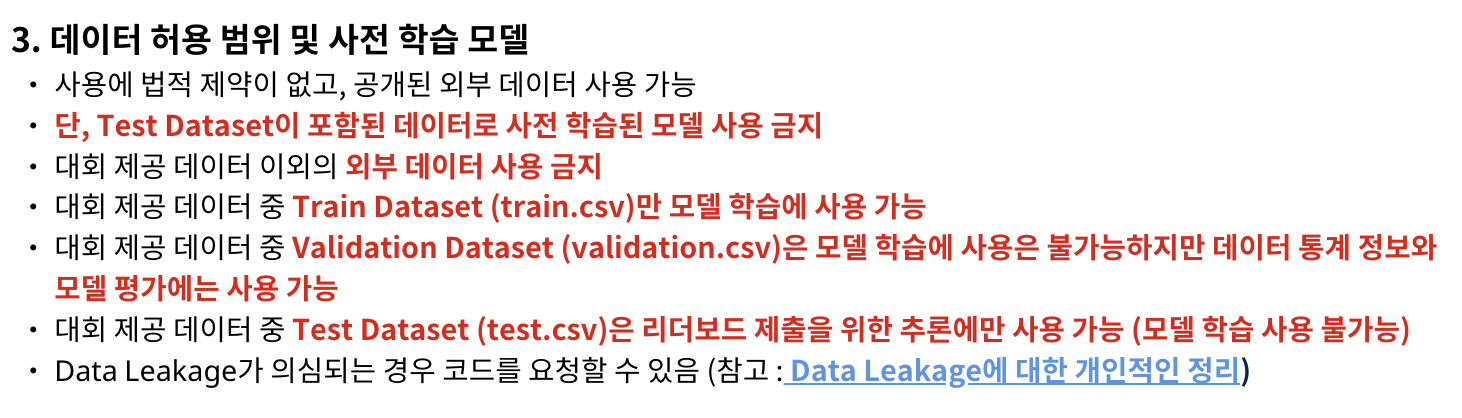

<br>

Stage 6에서 중요하게 봐야할 대회 규칙은 다음과 같습니다.<br><br>

  * <font color=darkblue>**외부 데이터 사용 금지**</font><br><br>
  * <font color=darkblue>**Train Data Set만 모델 학습 가능**</font><br><br>
  * <font color=darkblue>**Test Data Set은 추론에서만 사용 가능**</font><br><br>

우리는 이 점을 유의하여 모델링을 수행해야 할 것입니다.

<br>

# 3. Let's Start

<br>

여러분은 다시 중대한 임무를 맡게되었습니다. ⭐️

다양한 모델링 기법을 적용하여 <font color=blue>**Marco F1 Score**</font>를 높이기 위해 차근차근 배워봅시다.

## 3 - 1 대회에서 제공하는 데이터 셋 불러오기

In [1]:
# 데이터 불러오는 방법은 Stage 1 참조
import pandas as pd

In [2]:
train = pd.read_csv('./train.csv') # 훈련 데이터 셋
val = pd.read_csv('./val.csv') # 검증 데이터 셋
test = pd.read_csv('./test.csv') # 테스트 데이터 셋

## 3 - 2 Base Line 살펴보기

<br>

[[Baseline] Anomaly Detection with IsolationForest (비지도학습)](https://dacon.io/competitions/official/235930/codeshare/5236?page=1&dtype=recent)

<br>

### **Base Line 주요 특징**<br><br>

  * 특별한 전처리 및 특성 공학을 수행하지 않았습니다.<br><br>

  * Isolation Forest 모델 사용하였습니다.<br><br>

  * 모델의 하이퍼 파리미터 중 'contamination'을 Val Data Set 사기 거래 비율을 사용하였습니다.<br><br>

### **Base Line 모델 성능 평가하기**

<br>

불필요한 칼럼 제거

<br>

In [65]:
X_train = train.drop(columns=['ID'])

X_val = val.drop(columns=['ID', 'Class'])
y_val = val['Class']

X_test = test.drop(columns=['ID'])

<br>

'contamination' 하이퍼 파라미터 설정값 계산하기

<br>

In [5]:
val_normal, val_anomaly = val['Class'].value_counts()
val_contamination = val_anomaly / val_normal

print(f'Validation contamination : [{val_contamination}]')

Validation contamination : [0.0010551491277433877]


<br>

모델 학습하기

<br>

In [6]:
# sklearn 라이브러리에서 ensemble 중에서 IsolationForest를 불러옵니다.
# 자세한 내용은 Stage 3 참조해주세요.
from sklearn.ensemble import IsolationForest

In [8]:
# 모델을 용이하게 사용하게 별도로 변수로 지정합니다.
model = IsolationForest(n_estimators=125,  # 몇 개의 트리 기반 모델을 생성할 것인지 결정합니다.
                        max_samples=len(X_train), # 무작위로 복원 추출할 데이터의 개수를 결정합니다.
                        contamination=val_contamination, # 데이터 셋에 몇 개의 이상치가 존재하는 비율을 설정합니다.
                        random_state=42, # 동일한 결과물을 출력하도록 설정합니다.
                        verbose=0)

model.fit(X_train)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.0010551491277433877, max_samples=113842,
                n_estimators=125, random_state=42)

<br>

Val Data Set 추론하기

<br>

In [14]:
import numpy as np

In [15]:
# 모델 추론 값을 대회에 부합하게 변경합니다.
def get_pred_label(model_pred):

    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    
    return model_pred

In [16]:
val_pred = model.predict(X_val) # model prediction
val_pred = get_pred_label(val_pred)

<br>

Val Date Set에 관한 추론 결과 성능 평가하기

<br>

In [10]:
# sklearn 라이브러리에서 metrics 중에서 필요한 함수를 불러옵니다.
# 자세한 내용은 Stage 3 참조해주세요.
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # F1-Score
from sklearn.metrics import classification_report # 분류 성능을 종합적으로 나타냅니다.

In [17]:
val_score = f1_score(y_val, val_pred, average='macro')
recall = recall_score(y_val, val_pred)
precision = precision_score(y_val, val_pred)

print(f'Marco F1 Score : {val_score}\n')
print(f'Recall : {recall}\n')
print(f'Precision : {precision}\n')

print(classification_report(y_val, val_pred))

Marco F1 Score : 0.7030820840915222

Recall : 0.4

Precision : 0.41379310344827586

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.41      0.40      0.41        30

    accuracy                           1.00     28462
   macro avg       0.71      0.70      0.70     28462
weighted avg       1.00      1.00      1.00     28462



In [18]:
# 횬동 행렬를 계산합니다.
from sklearn.metrics import confusion_matrix

# 시각화 라이브러리
# 자세한 내용은 Stage 4를 참조해주세요.
import matplotlib.pyplot as plt

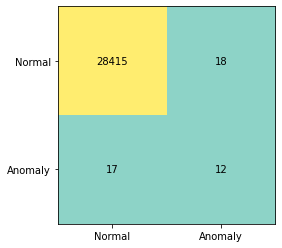

In [63]:
# 혼동 행렬를 구합니다.
cf_matrix = confusion_matrix(y_val, val_pred)

# 혼동 행렬을 Heat Map로 시각화합니다.
plt.imshow(cf_matrix, cmap='Set3')

# 할당된 값을 표시합니다.
plt.text(0, 0, cf_matrix[0][0], ha='center', va='center')
plt.text(0, 1, cf_matrix[0][1], ha='center', va='center')
plt.text(1, 0, cf_matrix[1][0], ha='center', va='center')
plt.text(1, 1, cf_matrix[1][1], ha='center', va='center')

# X축과 Y축을 설정합니다.
plt.xticks([0, 1], labels=['Normal', 'Anomaly'])
plt.yticks([0, 1], labels=['Normal', 'Anomaly'])

plt.show()

<br>

Pulic 및 Private Score 구하기<br><br>

  * **Pulic Score** : 0.6861376177<br><br>
  * **Private Score** :0.6877388427<br><br>

In [66]:
test_pred = model.predict(X_test) # model prediction
test_pred = get_pred_label(test_pred)

In [68]:
submit = pd.read_csv('./sample_submission.csv')
submit['Class'] = test_pred

In [69]:
submit.to_csv('./baseline.csv', index=False)

<br>

## 3 - 2 Base Line 기반으로 모델링 성능 올리기

<br>

### 다양한 전처리 및 특성 공학 적용하기

<br>

  * **Feature Selection**<br><br>

      * Isolate Forest는 각 특성의 값을 이용하여 분류를 수행합니다.

      * 모든 특성이 분류하는데 도움을 주지 않습니다.

      * Stage 5에서 각 특성 별로 히스토그램과 박스 플랏을 그렸던 것을 기억해보세요.

      * 시각화한 결과를 바탕으로 일부 칼럼만 사용할 것입니다.<br><br>

  * **Scaling & Derived Variable**<br><br>

      * 특정 변수만 사용하여 산점도를 그렸을 때 정상 거래와 사기 거래를 구별하기 힘든 데이터가 있었던 것으 기억할 것입니다.

      * 기존 변수를 활용하여 파생 변수를 생성한다면 더 다양한 패턴의 데이터가 나올 것입니다.

      * 기존 변수로 파생 변수를 만들기에는 데이터의 분포가 0을 중심으로 분포되어 있으며 각 특징 별로 분포의 형태가 다릅니다.

      * 그렇기에 Scaling 기법을 적용하여 각 특성 별 데이터가 특정 범위에 들도록 합니다.<br><br>

  * **dimension reduction**<br><br>

      * 파생 변수로 생긴 여러 특성 중 불필요한 특성은 제거합니다.<br><br>

<br>

#### 데이터 불러오기

<br>

In [70]:
train = pd.read_csv('./train.csv') # 훈련 데이터 셋
val = pd.read_csv('./val.csv') # 검증 데이터 셋
test = pd.read_csv('./test.csv') # 테스트 데이터 셋

<br>

#### Feature Selection

<br>

In [72]:
X_train = train.drop(columns=['ID'])

X_val = val.drop(columns=['ID', 'Class'])
y_val = val['Class']

X_test = test.drop(columns=['ID'])

In [73]:
# 시각화를 통해 확인되는 정상 거래와 사기 거래가 쉽게 구분되는 칼럼만 선택합니다.

X_train = X_train[['V3', 'V4', 'V9', 'V10', 'V11',
                   'V12', 'V14', 'V16', 'V17', 'V18']]

X_val = X_val[['V3', 'V4', 'V9', 'V10', 'V11',
               'V12', 'V14', 'V16', 'V17', 'V18']]

X_test = X_test[['V3', 'V4', 'V9', 'V10', 'V11',
                 'V12', 'V14', 'V16', 'V17', 'V18']]

In [74]:
print(f'사용되는 칼럼의 개수 : {len(X_train.columns)}')

사용되는 칼럼의 개수 : 10


<br>

#### Scaling

<br>

In [76]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [77]:
# 박스 플랏을 통해 IQR를 기준으로 이상치가 상대적으로 다수 존재하기에 Robust Scaler를 적용시킵니다.

scaler = RobustScaler(quantile_range=(25.0, 75.0))

scaled_train = scaler.fit_transform(X_train)
scaled_val = scaler.transform(X_val)
scaled_test = scaler.transform(X_test)

scaled_train = pd.DataFrame(scaled_train)
scaled_val = pd.DataFrame(scaled_val)
scaled_test = pd.DataFrame(scaled_test)

In [78]:
# 각 칼럼 별 합의 평균을 구하여 파생 변수를 생성할 예정입니다.
# Robust Scaler를 적용시켰기에 데이터 중에서 음수와 양수가 각각 존재합니다.
# MinMax Scaler를 적용시켜 데이터 값이 0에서 1사이에 존재하도록 합니다.

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(scaled_train)
scaled_val = scaler.transform(scaled_val)
scaled_test = scaler.transform(scaled_test)

scaled_train = pd.DataFrame(scaled_train)
scaled_val = pd.DataFrame(scaled_val)
scaled_test = pd.DataFrame(scaled_test)

<br>

#### Derived Variable

<br>

In [80]:
from itertools import combinations

In [82]:
# 칼럼 중에서 중복되지 않게 무작위로 5개를 뽑았을 때의 경우의 수를 생성합니다.

main_columns = list(scaled_train.columns)

com_main = list(combinations(main_columns, 5))
print(len(com_main))
print(com_main)

252
[(0, 1, 2, 3, 4), (0, 1, 2, 3, 5), (0, 1, 2, 3, 6), (0, 1, 2, 3, 7), (0, 1, 2, 3, 8), (0, 1, 2, 3, 9), (0, 1, 2, 4, 5), (0, 1, 2, 4, 6), (0, 1, 2, 4, 7), (0, 1, 2, 4, 8), (0, 1, 2, 4, 9), (0, 1, 2, 5, 6), (0, 1, 2, 5, 7), (0, 1, 2, 5, 8), (0, 1, 2, 5, 9), (0, 1, 2, 6, 7), (0, 1, 2, 6, 8), (0, 1, 2, 6, 9), (0, 1, 2, 7, 8), (0, 1, 2, 7, 9), (0, 1, 2, 8, 9), (0, 1, 3, 4, 5), (0, 1, 3, 4, 6), (0, 1, 3, 4, 7), (0, 1, 3, 4, 8), (0, 1, 3, 4, 9), (0, 1, 3, 5, 6), (0, 1, 3, 5, 7), (0, 1, 3, 5, 8), (0, 1, 3, 5, 9), (0, 1, 3, 6, 7), (0, 1, 3, 6, 8), (0, 1, 3, 6, 9), (0, 1, 3, 7, 8), (0, 1, 3, 7, 9), (0, 1, 3, 8, 9), (0, 1, 4, 5, 6), (0, 1, 4, 5, 7), (0, 1, 4, 5, 8), (0, 1, 4, 5, 9), (0, 1, 4, 6, 7), (0, 1, 4, 6, 8), (0, 1, 4, 6, 9), (0, 1, 4, 7, 8), (0, 1, 4, 7, 9), (0, 1, 4, 8, 9), (0, 1, 5, 6, 7), (0, 1, 5, 6, 8), (0, 1, 5, 6, 9), (0, 1, 5, 7, 8), (0, 1, 5, 7, 9), (0, 1, 5, 8, 9), (0, 1, 6, 7, 8), (0, 1, 6, 7, 9), (0, 1, 6, 8, 9), (0, 1, 7, 8, 9), (0, 2, 3, 4, 5), (0, 2, 3, 4, 6), (0, 2, 3,

In [83]:
# 5개의 칼럼을 더한 후 계산된 평균값을 파생 변수로 활용합니다.
for com in com_main:

  x = com[0]
  y = com[1]
  z = com[2]
  w = com[3]
  v = com[-1]

  scaled_train[f'{x}_{y}_{z}_{w}_{v}_mean'] = (scaled_train[x] + \
                                                scaled_train[y] + \
                                                scaled_train[z] + \
                                                scaled_train[w] + \
                                                scaled_train[v]) / 5

  scaled_val[f'{x}_{y}_{z}_{w}_{v}_mean'] = (scaled_val[x] + \
                                              scaled_val[y] + \
                                              scaled_val[z] + \
                                              scaled_val[w] + \
                                              scaled_val[v]) / 5

  scaled_test[f'{x}_{y}_{z}_{w}_{v}_mean'] = (scaled_test[x] + \
                                              scaled_test[y] + \
                                              scaled_test[z] + \
                                              scaled_test[w] + \
                                              scaled_test[v]) / 5

<ipython-input-83-d5cd7f40afdb>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  scaled_train[f'{x}_{y}_{z}_{w}_{v}_mean'] = (scaled_train[x] + \
<ipython-input-83-d5cd7f40afdb>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  scaled_val[f'{x}_{y}_{z}_{w}_{v}_mean'] = (scaled_val[x] + \
<ipython-input-83-d5cd7f40afdb>:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

In [84]:
print(f'사용되는 칼럼의 개수 : {len(scaled_train.columns)}')

사용되는 칼럼의 개수 : 262


<br>

#### dimension reduction

<br>

**Sparse Random Projection**<br><br>

  * 존슨-린텐슈트라우스 보조정리를 활용하여 차원 축소를 실행합니다.<br><br>

  * 고차원 공간의 데이터 포인터들은 포인트 사이의 거리가 거의 보존되는 방식으로 훨씬 더 낮은 차원의 공간에 삽입될 수 있습니다.<br><br>

  * 즉, 고차원 공간에서 저차원 공간으로 이동하는 경우에도 원본 피처 셋의 핵심 정보가 유지됩니다.<br><br>
  * 가우시안 랜덤 투영에 비해 희소성이 유지되며 속도가 빠릅니다.<br><br>

In [86]:
from sklearn.random_projection import SparseRandomProjection

In [109]:
dimesion_reducer = SparseRandomProjection(n_components=128,
                                          eps=0.1,
                                          random_state=42)

In [110]:
SRP_train = dimesion_reducer.fit_transform(scaled_train)
SRP_val = dimesion_reducer.transform(scaled_val)
SRP_test = dimesion_reducer.transform(scaled_test)

SRP_train = pd.DataFrame(SRP_train)
SRP_val = pd.DataFrame(SRP_val)
SRP_test = pd.DataFrame(SRP_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [111]:
print(f'사용되는 칼럼의 개수 : {len(SRP_train.columns)}')

사용되는 칼럼의 개수 : 128


<br>

### 하이퍼파리미터 튜닝

<br>

  * **n_estimators**<br><br>

    * 더 많은 작은 트리를 다양한 경우의 수의 추론 값을 생성합니다.
    * 이를 통해 과대 적합을 방지합니다.

  * **max_samples**<br><br>

    * 훈련 데이터 셋에 일부 사기 거래 데이터가 포함되어있습니다.
    * 훈련 데이터 셋 중 일부만 사용하여 사기 거래 데이터가 포함되는 경우를 감소시킵니다.

  * **max_features**<br><br>

    * 일부 칼럼만 사용하여 차원의 저주를 방지합니다.
    * 다양한 칼럼 조합을 사용하여 과대적합을 방지합니다.<br><br>

In [116]:
# 모델을 용이하게 사용하게 별도로 변수로 지정합니다.
model = IsolationForest(n_estimators=300,
                        max_samples=0.9, 
                        max_features=0.3,
                        contamination=val_contamination,
                        random_state=42,
                        verbose=0)

model.fit(SRP_train)

IsolationForest(contamination=0.0010551491277433877, max_features=0.3,
                max_samples=0.9, n_estimators=300, random_state=42)

<br>

### 모델 성능 평가하기

<br>

Base Line보다 성능이 향상되었음을 확인할 수 있습니다.

<br>

In [117]:
val_pred = model.predict(SRP_val) # model prediction
val_pred = get_pred_label(val_pred)

In [118]:
val_score = f1_score(y_val, val_pred, average='macro')
recall = recall_score(y_val, val_pred)
precision = precision_score(y_val, val_pred)

print(f'Marco F1 Score : {val_score}\n')
print(f'Recall : {recall}\n')
print(f'Precision : {precision}\n')

print(classification_report(y_val, val_pred))

Marco F1 Score : 0.8394731804484362

Recall : 0.6

Precision : 0.782608695652174

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.78      0.60      0.68        30

    accuracy                           1.00     28462
   macro avg       0.89      0.80      0.84     28462
weighted avg       1.00      1.00      1.00     28462



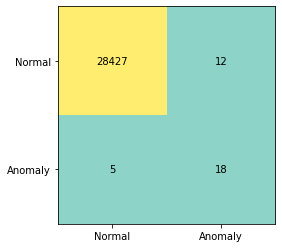

In [119]:
# 혼동 행렬를 구합니다.
cf_matrix = confusion_matrix(y_val, val_pred)

# 혼동 행렬을 Heat Map로 시각화합니다.
plt.imshow(cf_matrix, cmap='Set3')

# 할당된 값을 표시합니다.
plt.text(0, 0, cf_matrix[0][0], ha='center', va='center')
plt.text(0, 1, cf_matrix[0][1], ha='center', va='center')
plt.text(1, 0, cf_matrix[1][0], ha='center', va='center')
plt.text(1, 1, cf_matrix[1][1], ha='center', va='center')

# X축과 Y축을 설정합니다.
plt.xticks([0, 1], labels=['Normal', 'Anomaly'])
plt.yticks([0, 1], labels=['Normal', 'Anomaly'])

plt.show()

In [120]:
test_pred = model.predict(SRP_test) # model prediction
test_pred = get_pred_label(test_pred)

In [121]:
submit = pd.read_csv('./sample_submission.csv')
submit['Class'] = test_pred

In [122]:
submit.to_csv('./Isolate_Forest.csv', index=False)

<br>

## Quiz 1

  * 다양한 전처리 및 특성 공학 기법과 하이퍼 파리미터 튜닝을 통해 성능을 높여보세요.

**Hint**

  * 변수 선택 및 차원 축소를 다르게 설정할 수 있습니다.

  * 새로운 아이디어로 파생 변수를 생성할 수 있습니다.



```
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, TruncatedSVD, FastICA
from sklearn.cluster import KMeans
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
```



In [ ]:
# 실습
train = pd.read_csv('./train.csv') # 훈련 데이터 셋
val = pd.read_csv('./val.csv') # 검증 데이터 셋
test = pd.read_csv('./test.csv') # 테스트 데이터 셋

# 전처리 및 특성 공학



# 모델 학습

model = IsolationForest(random_state=42,
                        verbose=0)

model.fit(train)


# 모델 성능 평가

val_pred = model.predict(val) # model prediction
val_pred = get_pred_label(val_pred)

val_score = f1_score(y_val, val_pred, average='macro')
recall = recall_score(y_val, val_pred)
precision = precision_score(y_val, val_pred)

print(f'Marco F1 Score : {val_score}\n')
print(f'Recall : {recall}\n')
print(f'Precision : {precision}\n')

print(classification_report(y_val, val_pred))

# 혼동 행렬를 구합니다.
cf_matrix = confusion_matrix(y_val, val_pred)

# 혼동 행렬을 Heat Map로 시각화합니다.
plt.imshow(cf_matrix, cmap='Set3')

# 할당된 값을 표시합니다.
plt.text(0, 0, cf_matrix[0][0], ha='center', va='center')
plt.text(0, 1, cf_matrix[0][1], ha='center', va='center')
plt.text(1, 0, cf_matrix[1][0], ha='center', va='center')
plt.text(1, 1, cf_matrix[1][1], ha='center', va='center')

# X축과 Y축을 설정합니다.
plt.xticks([0, 1], labels=['Normal', 'Anomaly'])
plt.yticks([0, 1], labels=['Normal', 'Anomaly'])

plt.show()

**Solution**

  * 정해진 정답은 없습니다. 자유롭게 수행하여 보세요.